# Using a Standardized Metrics to Understand Traffic Accidents vs Bike Lanes
In the previous analysis, I saw that traffic accidents are clearly going up over the years for all locations. Differences between effects of a bike lane vs without bike lane are lower in Mission than in Tenderloin. However not all locations have a lot of bike lanes in the first place. But this could be a function of the fact that some places have more bike lanes than other places.

I think it would be helpful to look at the ratio of accidents to bike lanes lengths vs the ratio of accidents to roads (without bike lanes lengths), per neighborhood.

Originally, I didn't pull up the bike laned vs not bike laned length of road ratios for each neighborhood especially since, given the time it could take, I'm not sure if it's the next move. But from some quick calculations, I found out that there are about ~200 miles of bike lanes vs 112,704.61  miles of actual road
* a bike lane in the [dataset](https://data.sfgov.org/Transportation/SFMTA-Bikeway-Network/ygmz-vaxd) is only on one side of the road - so this is an estimate from dividing 424 mi of bike lanes in half (I will have to account for 1w vs 2w roads to get a better number). I have reason to believe that there are duplicate values in this data set due to seeing the same geometry multiple times. I will have to investigate this by hand further
* a the [roads](https://data.sfgov.org/Geographic-Locations-and-Boundaries/Streets-Active-and-Retired/3psu-pn9h) dataset I was using counted a road as 1, regardless if it is was 1 way or two way.
So basically, comparing accident *counts* on and off a bike lane doesn't make sense as we're comparing things with different areas. 

## Standardized Metric
I am using a standardized metric to measure the number of accidents per meter of lane - in the district
- number of miles of road per area we are comparing with in (if we're comparing accidents within neighbor hood, divide number of accidents on a bike lane by number of miles per bike lane, and number of accidents off a bike lane by number of miles off a bike lane)

In [99]:
import pandas as pd
import numpy as np
import sqlite3
from plotnine import  # usually don't like to import like that, but there a lot of functions in plot nine that I need to import to make graphs work

In [4]:
traffic_reports_and_bikelanes3 = pd.read_csv( 'BikewayNetwork_edit/accidents_bikelanes_roads_wlengths.csv')

In [5]:
traffic_reports_and_bikelanes3.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'IncidntNum', 'Category', 'Descript',
       'DayOfWeek', 'Date', 'Time', 'PdDistrict', 'Resolution', 'Address', 'X',
       'Y', 'Location', 'PdId', 'accident_year', 'globalid', 'bikelane_exist',
       'install_yr_accid', 'barrier', 'biap', 'buffered', 'cnn_accid',
       'contraflow', 'date_creat', 'time_creat', 'created_us', 'dir', 'direct',
       'double', 'facility_t', 'from_st', 'fy', 'greenwave', 'install_mo',
       'install_yr_bikelane', 'date_last_', 'time_last_', 'last_edite',
       'length', 'notes', 'number', 'objectid', 'qtr', 'raised', 'shape_len',
       'sharrow', 'sm_sweeper', 'street_accid', 'streetname_accid',
       'surface_tr', 'symbology', 'to_st', 'update_mo', 'update_yr',
       'censusbloc', 'geometry_accid', '_merge', 'bikelane_installdate',
       'isWeekday', 'cnn_of_road', 'road_length', 'jurisdiction', 'zip_code',
       'f_node_cnn', 'date_dropped', 'gds_chg_id_add', 'classcode', 't_st',
       'accepted', 'street

In [6]:
accident_counts_bydistrict_bikelane_exist = traffic_reports_and_bikelanes3.groupby(['bikelane_exist', 'PdDistrict', 'accident_year', 'cnn_of_road', 'globalid', 'road_length', 'bikelane_length_haver']).agg({'Category':'count'}).reset_index()

accident_counts_bydistrict_bikelane_exist.rename( columns = {'Category': 'accident_counts'}, inplace = True)
accident_counts_bydistrict_bikelane_exist = accident_counts_bydistrict_bikelane_exist.groupby( ['bikelane_exist', 'PdDistrict', 'accident_year'], as_index = False)['accident_counts','road_length', 'bikelane_length_haver'].sum()

#accident_counts_bydistrict = traffic_reports_and_bikelanes.groupby([ 'PdDistrict']).count()['Category'].reset_index()
#accident_counts_bydistrict.rename( columns = {'Category': 'accident_counts'}, inplace = True)


C:\Users\Divya\anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


In [142]:
accident_counts_bydistrict_bikelane_exist.bikelane_exist.value_counts()

True     122
False     64
Name: bikelane_exist, dtype: int64

In [143]:
def calc_standard( row ):
    if row['bikelane_exist'] == "False":
        return (row['accident_counts']/row['road_length'] )
    else:
        return (row['accident_counts'] /row['bikelane_length_haver'])

In [144]:
accident_counts_bydistrict_bikelane_exist['std_metric'] = accident_counts_bydistrict_bikelane_exist.apply(calc_standard, axis = 1)

In [145]:
num_traffic_neighborhood = (ggplot(accident_counts_bydistrict_bikelane_exist, aes(x ='PdDistrict', y='std_metric', fill = 'bikelane_exist'))
 + geom_bar( stat='identity', position='dodge', show_legend=True) + theme(axis_text_x = element_text(angle=45)) + \
                            labs(title=('Number of Traffic Accidents per meter of road by Neighborhood'), x='Neighborhood', y='Number of Traffic Accidents', fill = "Does the road have Bike Lanes?") \
                           )

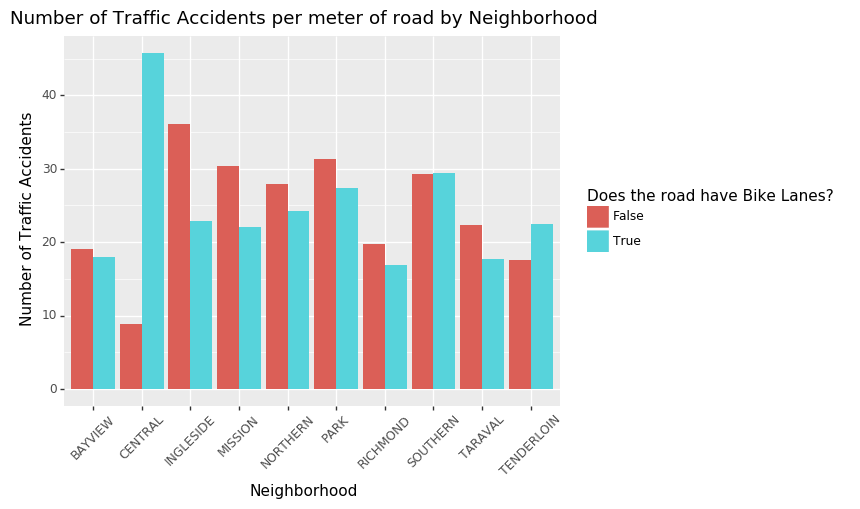

<ggplot: (-9223371933959021000)>

In [146]:
num_traffic_neighborhood

It appears that there are fewer accidents per mile of bike lane off a bike lane than on a bike lane. The trend deviates in the central district

## By neighborhood - Standardized Metric

In [147]:
accidentsby_ifhour_bikelane_day_district_std = traffic_reports_and_bikelanes3.groupby(['hour', 'bikelane_exist', 'isWeekday', 'PdDistrict','cnn_road','globalid', 'road_length', 'bikelane_length_haver'], as_index = False)['Category'].count().sort_values( by = ['bikelane_exist', 'hour'])
accidentsby_ifhour_bikelane_day_district_std = accidentsby_ifhour_bikelane_day_district_std.reset_index(drop = True)
accidentsby_ifhour_bikelane_day_district_std.rename( columns = {'Category': 'traffic_accidents'}, inplace = True)
accidentsby_ifhour_bikelane_day_district_std.bikelane_exist = accidentsby_ifhour_bikelane_day_district_std.bikelane_exist.apply( lambda x: "Yes" if x == True else "No")

In [148]:
# sum road length, bike lane length, traffic accident numbers by categories in question
accidentsby_ifhour_bikelane_day_district_std2 = accidentsby_ifhour_bikelane_day_district_std.groupby( ['hour', 'bikelane_exist', 'isWeekday', 'PdDistrict'], as_index=False)['traffic_accidents', 'road_length', 'bikelane_length_haver'].sum().sort_values( by =['bikelane_exist', 'hour'] )

C:\Users\Divya\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


In [150]:
accidentsby_ifhour_bikelane_day_district_std2.head(2)

,hour,bikelane_exist,isWeekday,PdDistrict,traffic_accidents,road_length,bikelane_length_haver
0,0,No,Weekday,MISSION,1,0.124375,0.066432
1,0,No,Weekday,PARK,1,0.124375,0.036984


In [152]:
accidentsby_ifhour_bikelane_day_district_std2.traffic_accidents.value_counts()

1     200
2      91
3      49
4      28
5      15
6      11
7       6
8       4
16      1
9       1
Name: traffic_accidents, dtype: int64

In [154]:
# sum road length, bike lane length, traffic accident numbers by categories in question
accidentsby_ifhour_bikelane_day_district_std2.rename( columns = {'traffic_accidents': 'accident_counts'}, inplace = True)

In [155]:
accidentsby_ifhour_bikelane_day_district_std2['std_metric'] = accidentsby_ifhour_bikelane_day_district_std2.apply(calc_standard, axis = 1)

In [156]:
accidentsby_ifhour_bikelane_day_district_plots_std = []

for j in (set(accidentsby_ifhour_bikelane_day_district_std2.PdDistrict)): #iterate over weekday vs 
    for i in set(accidentsby_ifhour_bikelane_day_district_std2.isWeekday ):
        df_hold2 = accidentsby_ifhour_bikelane_day_district_std2.loc[((accidentsby_ifhour_bikelane_day_district_std2.isWeekday == i) & (accidentsby_ifhour_bikelane_day_district_std2.PdDistrict == j))]
        accidentsby_ifhour_bikelane_day_district_plots_std.append((ggplot(df_hold2, aes(x='bikelane_exist', y = 'std_metric'))         # defining what data to use
         + geom_bar(aes(fill = 'bikelane_exist'), stat='identity') # aes(fill = 'hour')
         + coord_flip()
         + facet_wrap('hour')
         + labs(title=('Number of Traffic Accidents, with and without bike lane, during a hour of day, on a ' + i + ' in ' + j + '/n standard metric'), x='Does a Bike Lane Exist?', y='Number of Traffic Accidents'))
        )

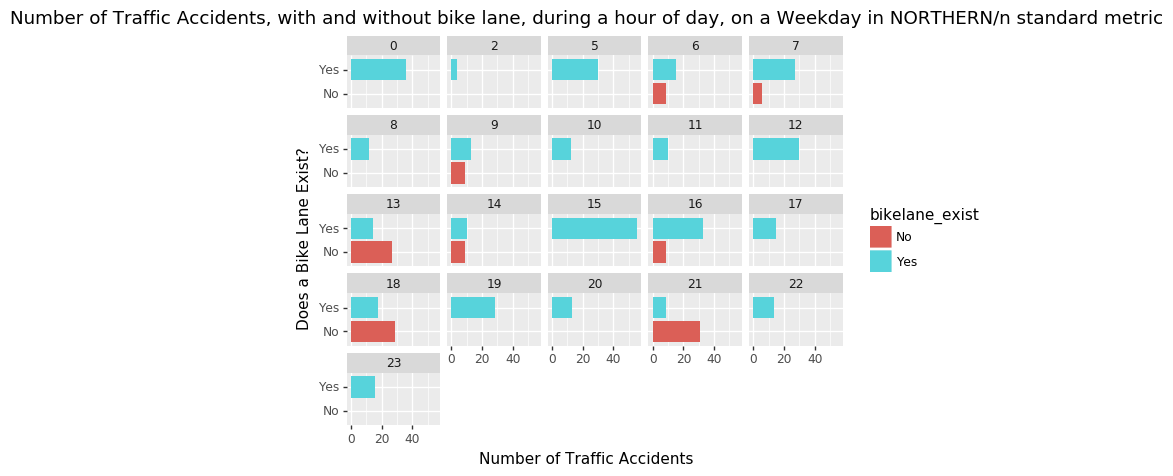

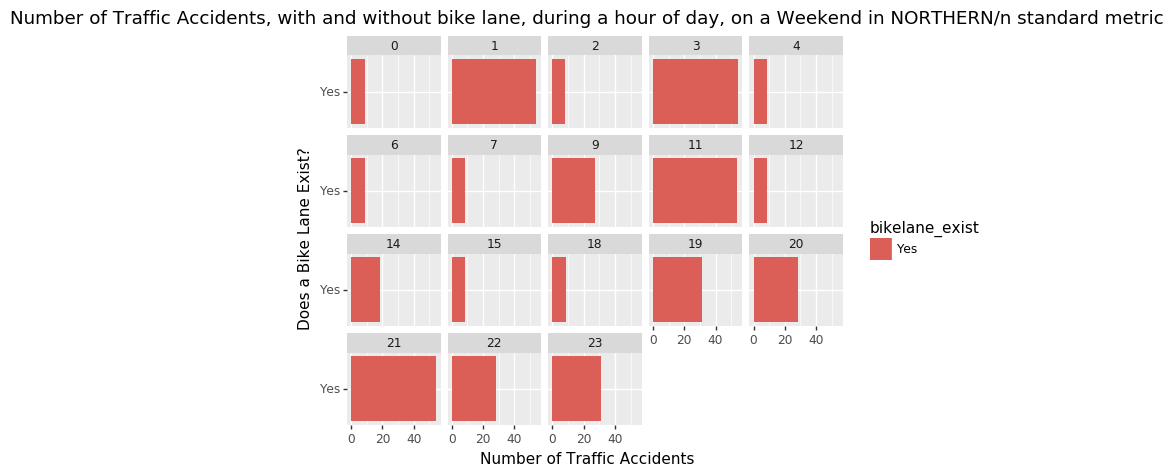

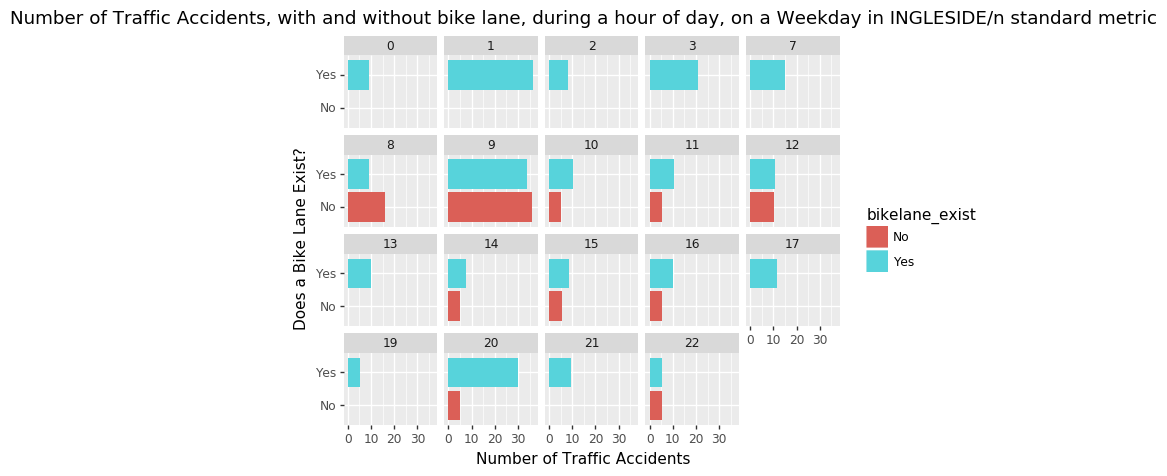

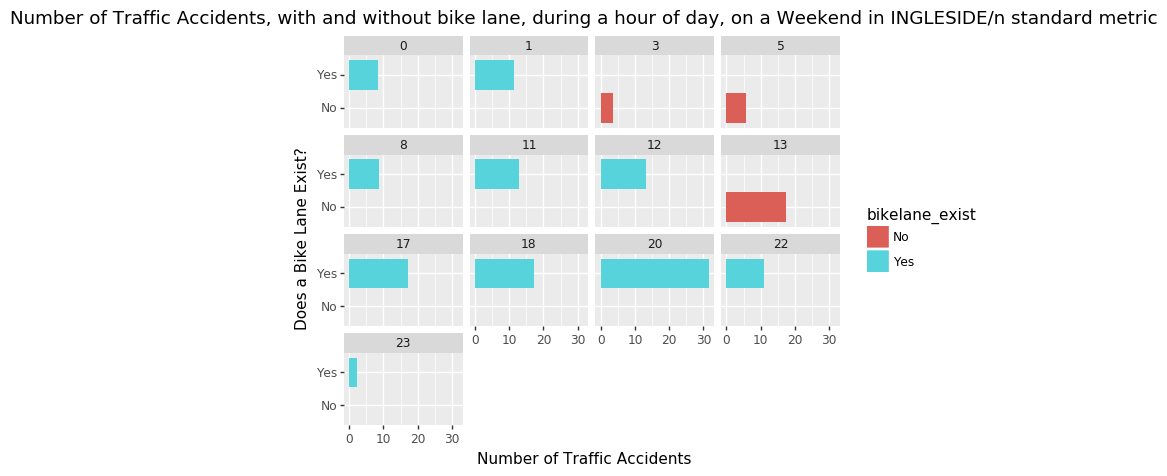

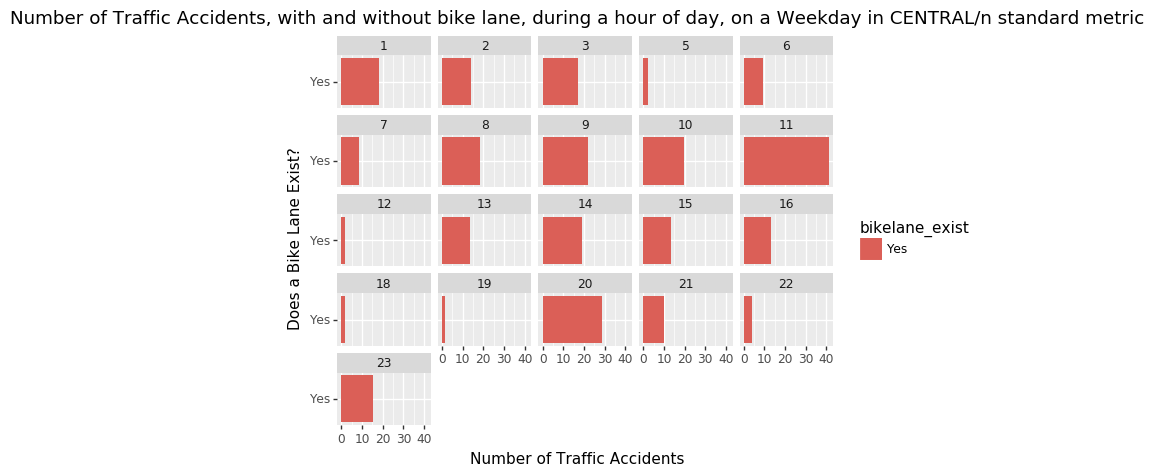

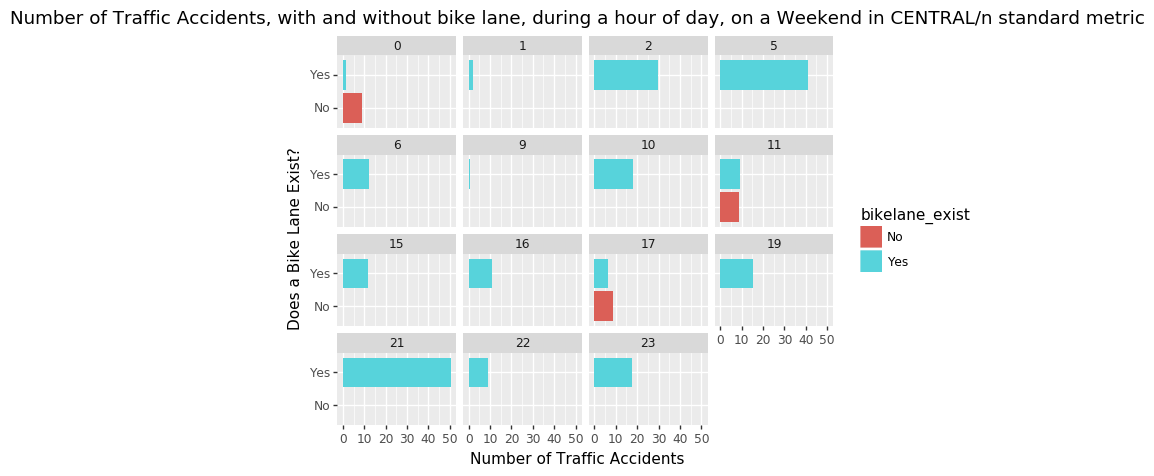

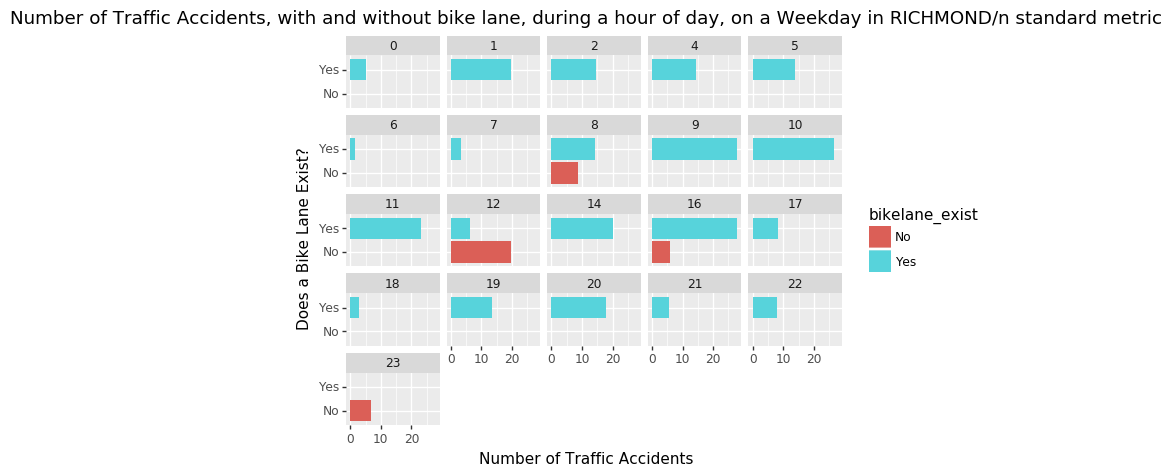

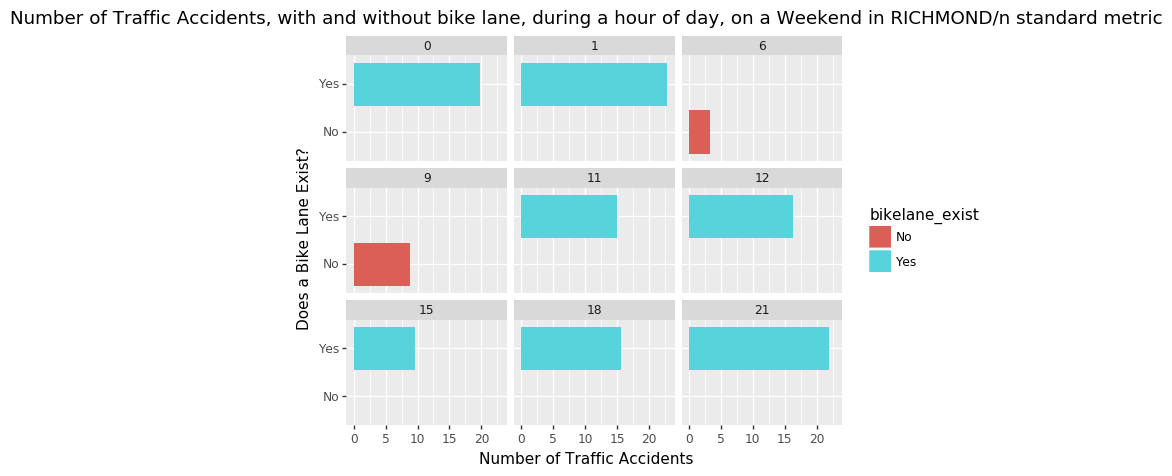

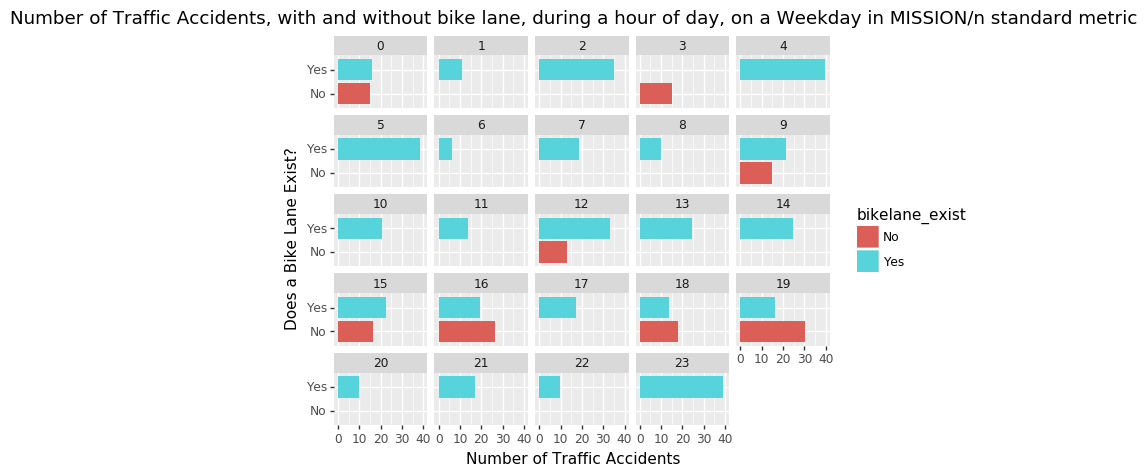

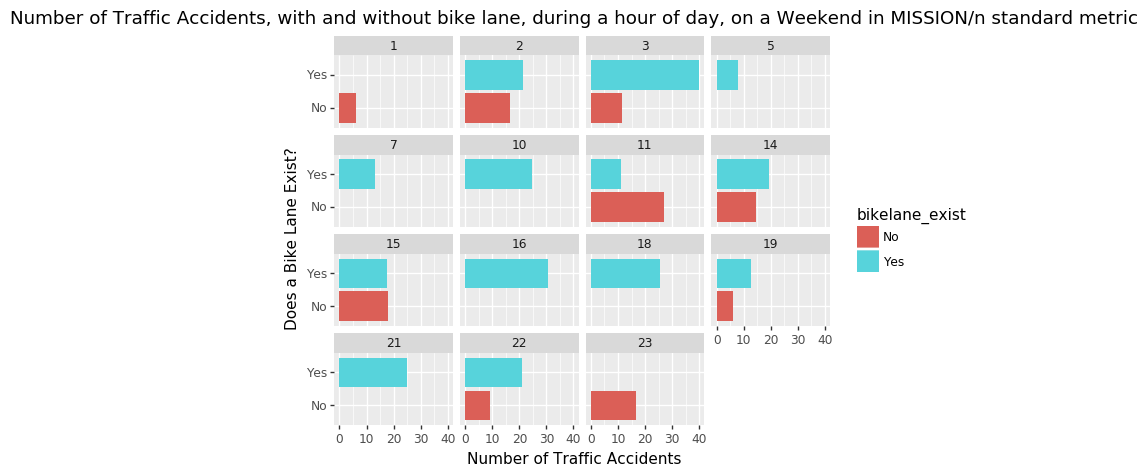

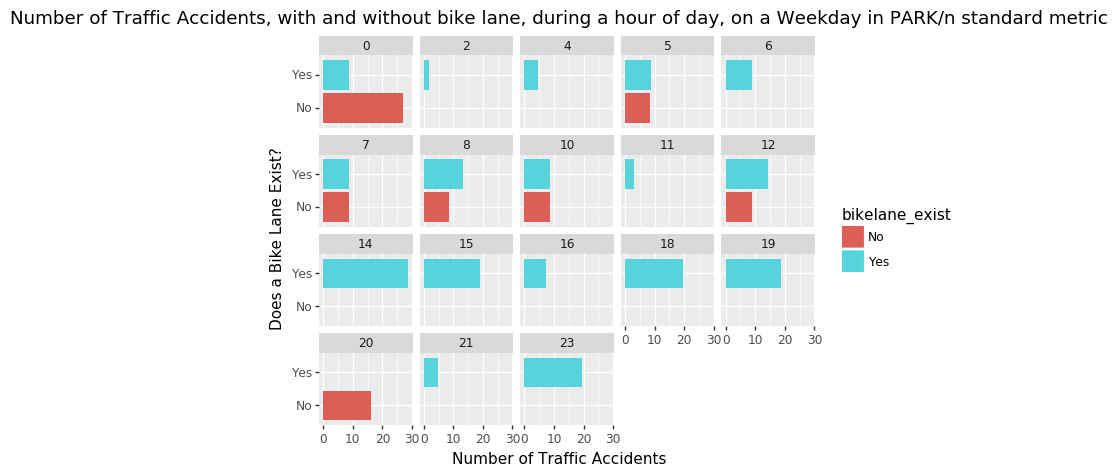

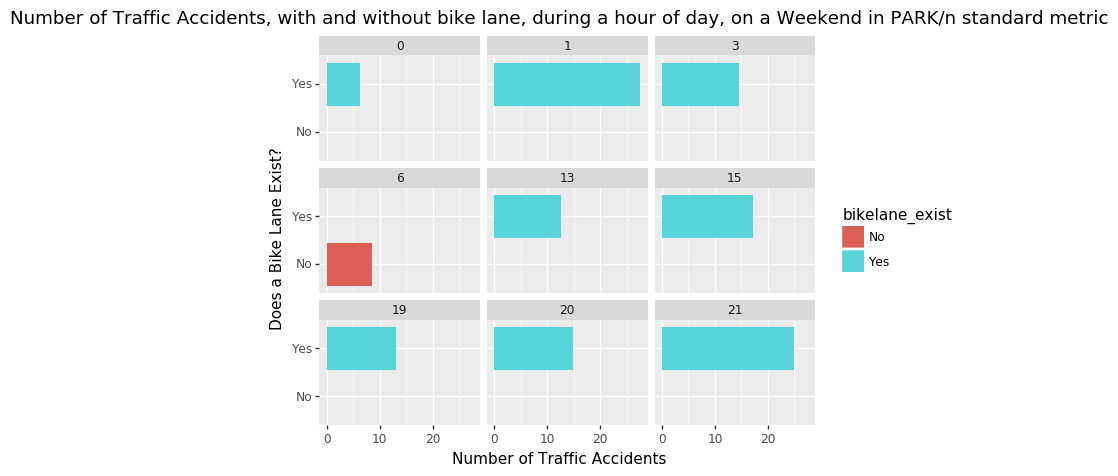

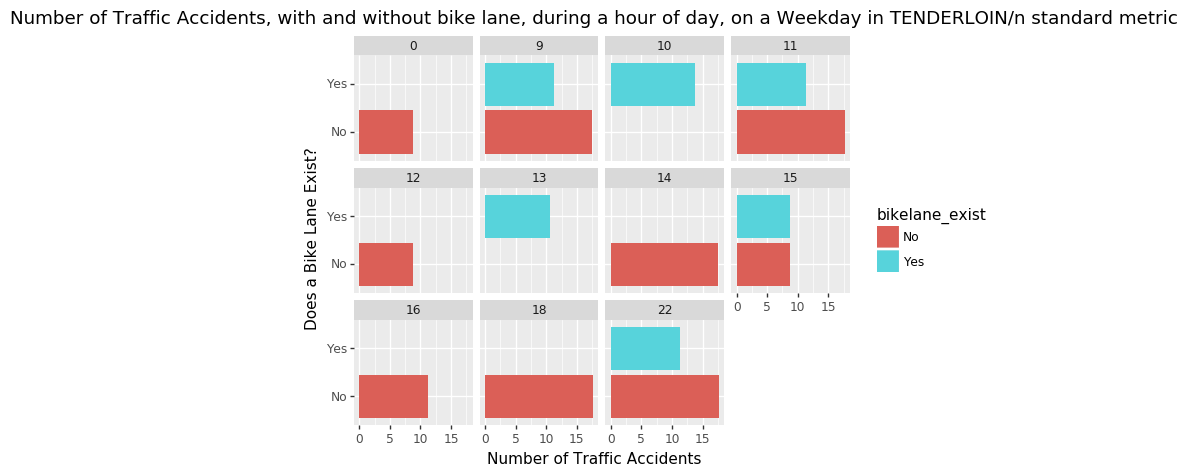

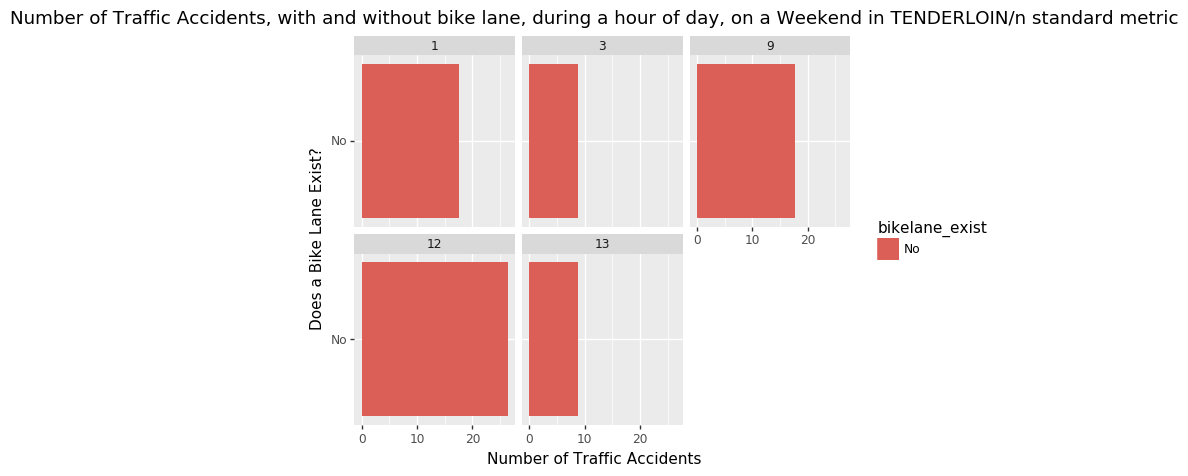

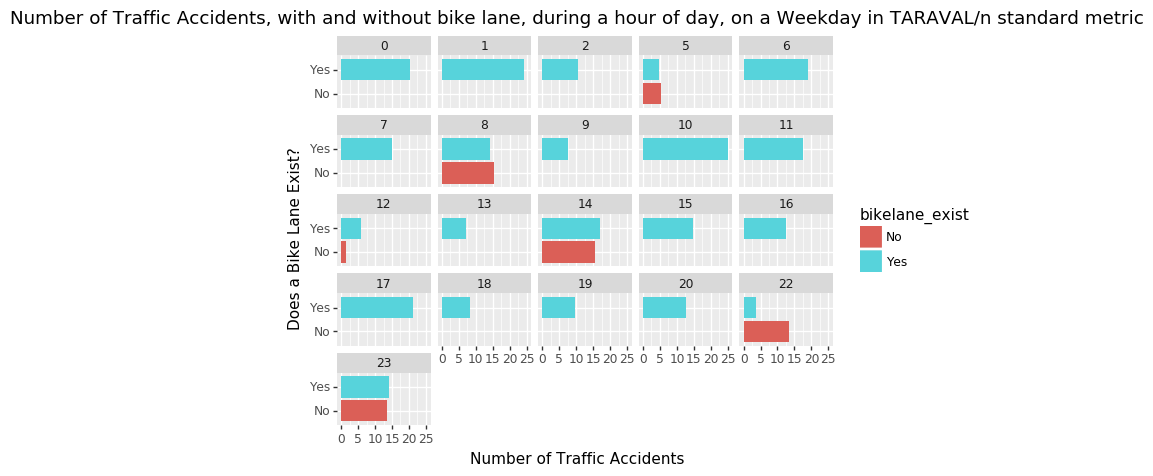

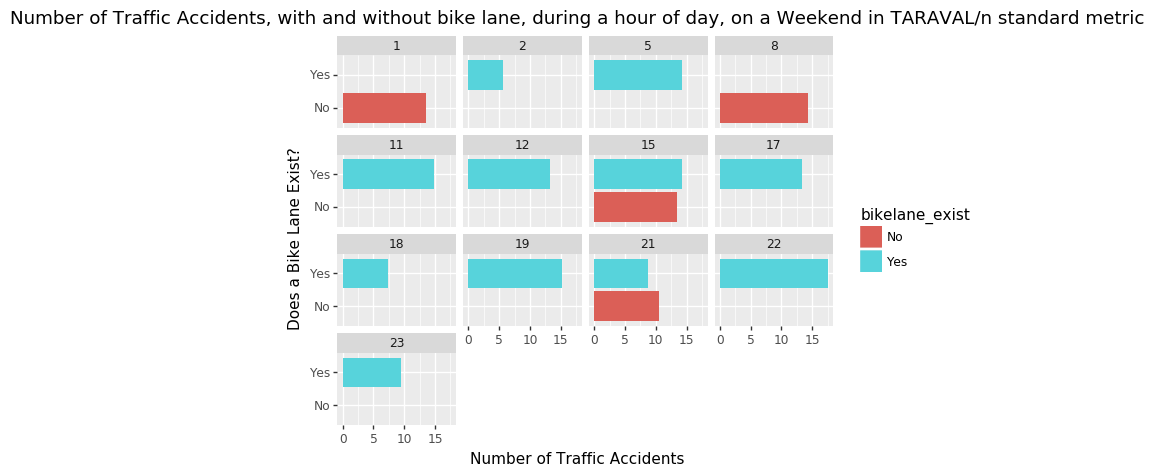

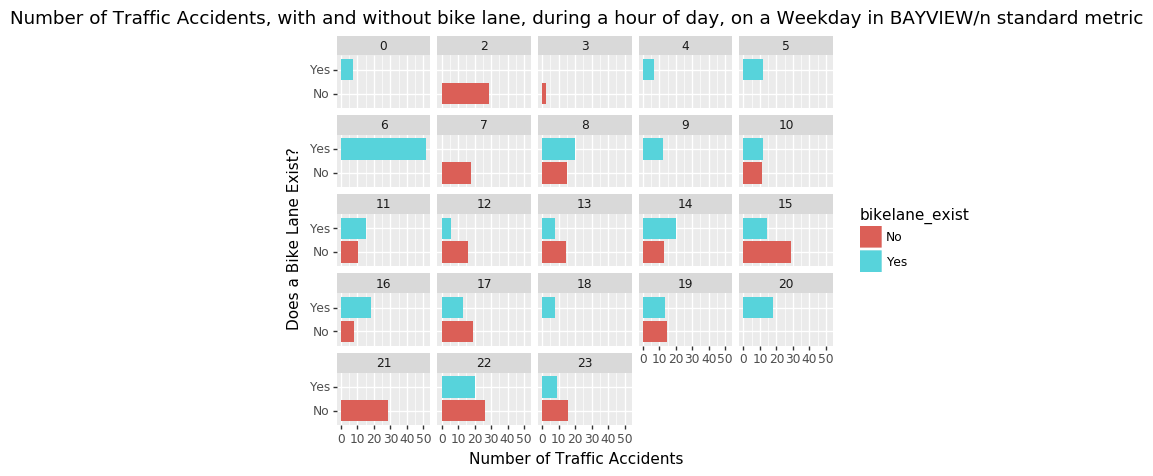

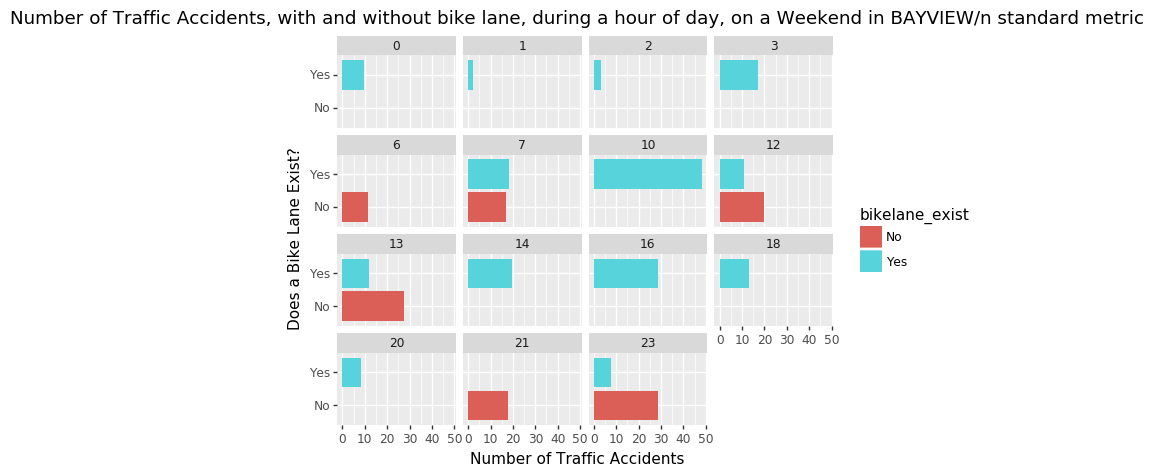

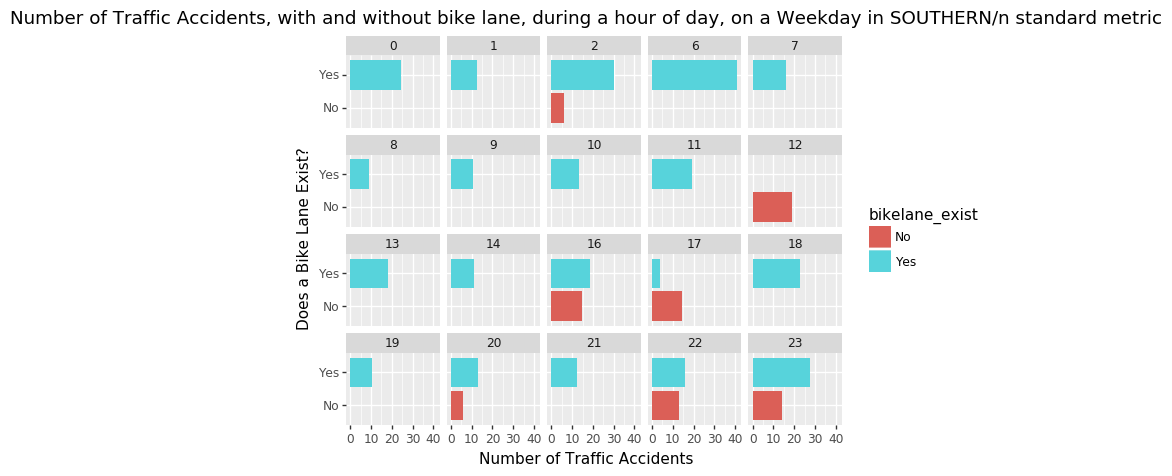

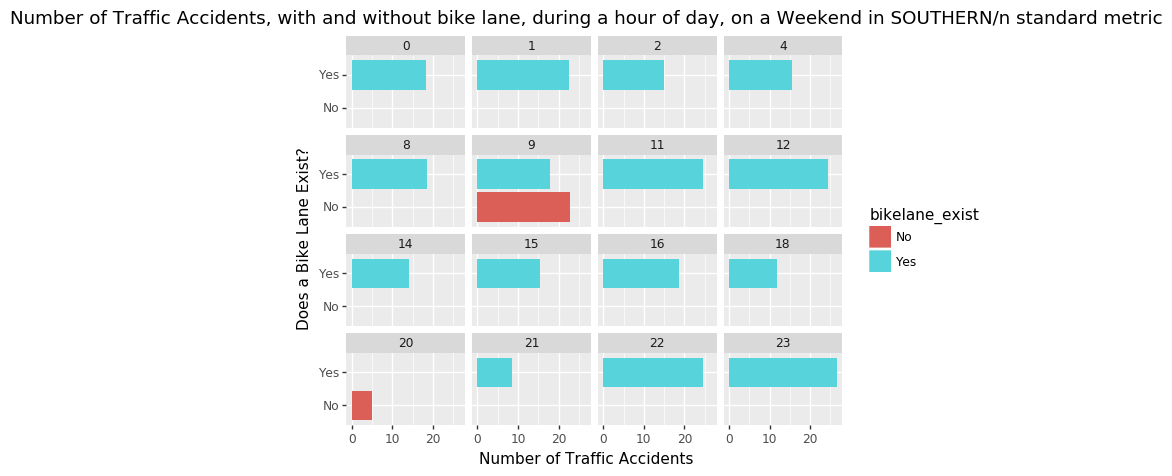

[<ggplot: (-9223371933958498872)>,
 <ggplot: (-9223371933958558936)>,
 <ggplot: (-9223371933961354520)>,
 <ggplot: (-9223371933961345672)>,
 <ggplot: (-9223371933958559480)>,
 <ggplot: (-9223371933958695396)>,
 <ggplot: (-9223371933959028404)>,
 <ggplot: (-9223371933958559372)>,
 <ggplot: (-9223371933957312928)>,
 <ggplot: (-9223371933957311284)>,
 <ggplot: (-9223371933957311472)>,
 <ggplot: (-9223371933957311456)>,
 <ggplot: (-9223371933957309584)>,
 <ggplot: (-9223371933957309216)>,
 <ggplot: (-9223371933957307480)>,
 <ggplot: (-9223371933957307488)>,
 <ggplot: (-9223371933957309472)>,
 <ggplot: (-9223371933957305868)>,
 <ggplot: (-9223371933957304388)>,
 <ggplot: (-9223371933957304396)>]

In [157]:
accidentsby_ifhour_bikelane_day_district_plots_std

Pretty much usually all accidents are on bike lanes than off bike lanes.

One thing that I notice is that weekends there tends to be accidents on bikelanes only. Maybe bikers just stick to bike lanes when thy exists, or bike around more when they exist? hence why we see more accidents on bikelanes?

But overall there aren't many accidents on either side, per district to be begin with

In [598]:
accidentsby_ifhour_bikelane_day_district_plots_std = []

for j in (set(accidentsby_ifhour_bikelane_day_district_std2.PdDistrict)): #iterate over weekday vs 
    for i in set(accidentsby_ifhour_bikelane_day_district_std2.isWeekday ):
        df_hold2 = accidentsby_ifhour_bikelane_day_district_std2.loc[((accidentsby_ifhour_bikelane_day_district_std2.isWeekday == i) & (accidentsby_ifhour_bikelane_day_district_std2.PdDistrict == j))]
        accidentsby_ifhour_bikelane_day_district_plots_std.append((ggplot(df_hold2, aes(x='bikelane_exist', y = 'std_metric'))         # defining what data to use
         + geom_bar(aes(fill = 'bikelane_exist'), stat='identity') # aes(fill = 'hour')
         + coord_flip()
         + facet_wrap('hour')
         + labs(title=('Number of Traffic Accidents, with and without bike lane, during a hour of day, on a ' + i + ' in ' + j + '/n standard metric'), x='Does a Bike Lane Exist?', y='Number of Traffic Accidents'))
        )

In [104]:
daysofweek_array = np.array(set(traffic_reports_and_bikelanes3.DayOfWeek )).tolist()
accidentsby_ifhour_bikelane = traffic_reports_and_bikelanes3.groupby(['cnn_of_road' ,'globalid','hour', 'bikelane_exist', 'DayOfWeek', 'isWeekday', 'road_length', 'bikelane_length_haver'], as_index = False)['Category'].count().sort_values( by = ['bikelane_exist', 'hour'])
accidentsby_ifhour_bikelane = accidentsby_ifhour_bikelane.reset_index(drop = True)
accidentsby_ifhour_bikelane.rename( columns = {'Category': 'traffic_accidents'}, inplace = True)
accidentsby_ifhour_bikelane.bikelane_exist = accidentsby_ifhour_bikelane.bikelane_exist.apply( lambda x: "Yes" if x == True else "No")

In [74]:
accidentsby_ifhour_bikelane.traffic_accidents.value_counts()

1    842
2     11
3      3
4      2
Name: traffic_accidents, dtype: int64

In [85]:
accidentsby_ifhour_bikelane2 = accidentsby_ifhour_bikelane.groupby(['hour', 'bikelane_exist', 'DayOfWeek', 'isWeekday'], as_index = False)['traffic_accidents', 'road_length', 'bikelane_length_haver'].sum().sort_values( by = ['bikelane_exist', 'hour', 'DayOfWeek'])

In [86]:
def calc_standard( row ):
    if row['bikelane_exist'] == "No":
        return (row['traffic_accidents']/row['road_length'] )
    else:
        return (row['traffic_accidents'] /row['bikelane_length_haver'])


In [87]:
accidentsby_ifhour_bikelane2['standardized_metric'] = accidentsby_ifhour_bikelane2.apply( lambda x: calc_standard(x) , axis = 1)

In [88]:
accidents_hour_bikelane_day_graphs_std =[]

for i in set(accidentsby_ifhour_bikelane2.isWeekday):
    accidents_hour_bikelane_day2 = accidentsby_ifhour_bikelane2.loc[traffic_reports_and_bikelanes.isWeekday == i, ['bikelane_exist', 'hour', 'standardized_metric']]
    accidents_hour_bikelane_day_graphs_std.append((ggplot(accidents_hour_bikelane_day2, aes(x='bikelane_exist', y = 'standardized_metric'))         # defining what data to use
     + geom_bar(aes(fill = 'bikelane_exist'), stat='identity') # aes(fill = 'hour')
     + coord_flip()
     + facet_wrap('hour')
     + labs(title=('Number of Traffic Accidents, by bike lane, time of day on ' + i), x='Does a Bike Lane Exist?', y='Number of Traffic Accidents'))
)

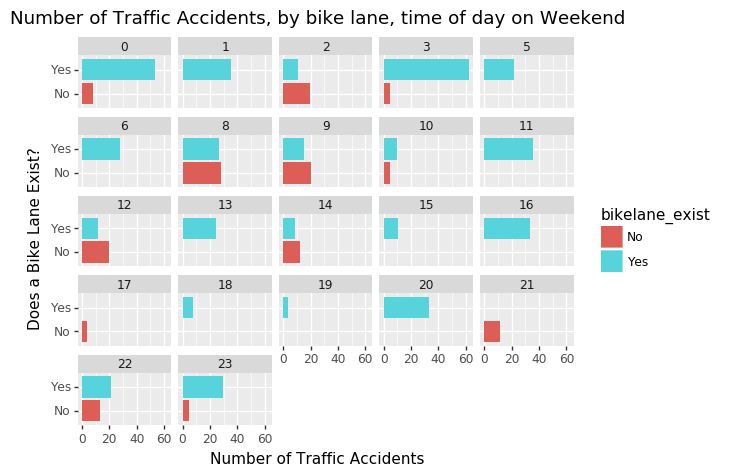

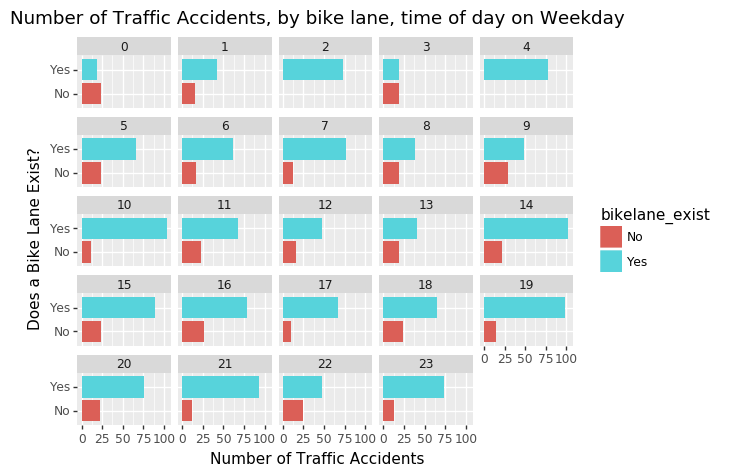

[<ggplot: (168674888491)>, <ggplot: (-9223371868179891810)>]

In [89]:
accidents_hour_bikelane_day_graphs_std

With the standardized metric, there are clearly more accidents on a bike lane, than not on a bike lane, at most hours of the day.

During traffic hours (6-9, 4-7), this trend remains. 

In [107]:
accidentsby_ifhour_bikelane.head(2)

,cnn_of_road,globalid,hour,bikelane_exist,DayOfWeek,isWeekday,road_length,bikelane_length_haver,traffic_accidents
0,6576101.0,{14C9F102-61B8-4075-945F-D5378086EBDE},0,No,Monday,Weekday,0.124375,0.113593,1
1,6576101.0,{1B2BC8A7-AF42-4CEB-973B-DCE094D76AAE},0,No,Wednesday,Weekday,0.124375,0.066432,1


In [ ]:
I'm going to group accidents by times in the day:
7-10, 11-3, 4-7, 8-12, 12-6

In [108]:
def times_of_day( hour ):
    if hour < 6:
        return "midnight_6am"
    if hour <11:
        return "morning rush"
    if hour < 4:
        return "afternoon"
    if hour < 8:
        return "evening rush"
    else:
        return "night"

In [110]:
accidentsby_ifhour_bikelane['times_of_day'] = accidentsby_ifhour_bikelane.hour.apply(lambda x: times_of_day(x) )

In [114]:
accidents_bikelaneexist_timesofday = accidentsby_ifhour_bikelane.groupby(['times_of_day', 'bikelane_exist'], as_index = False)['traffic_accidents'].sum()

In [115]:
accidents_bikelaneexist_timesofday

,times_of_day,bikelane_exist,traffic_accidents
0,midnight_6am,No,19
1,midnight_6am,Yes,125
2,morning rush,No,40
3,morning rush,Yes,130
4,night,No,87
5,night,Yes,480


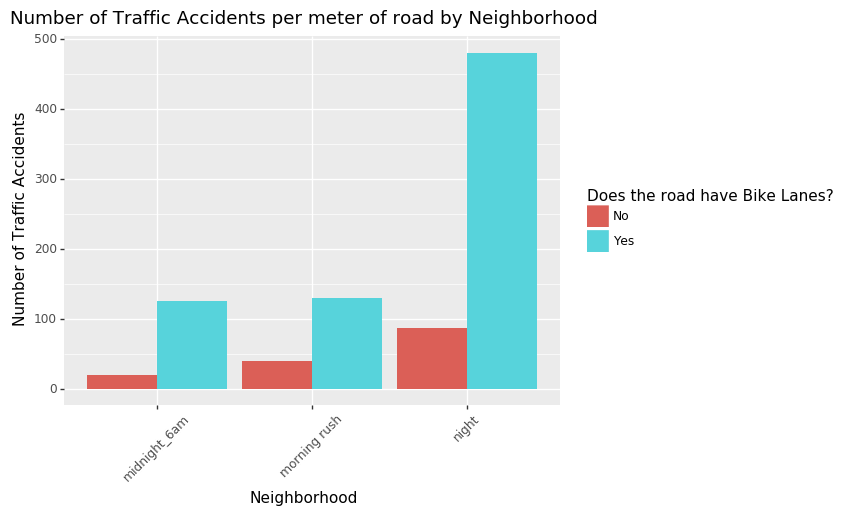

<ggplot: (-9223371933958687424)>

In [116]:
 (ggplot(accidents_bikelaneexist_timesofday, aes(x ='times_of_day', y='traffic_accidents', fill = 'bikelane_exist'))
 + geom_bar( stat='identity', position='dodge', show_legend=True) + theme(axis_text_x = element_text(angle=45)) + \
                            labs(title=('Number of Traffic Accidents per meter of road by Neighborhood'), x='Neighborhood', y='Number of Traffic Accidents', fill = "Does the road have Bike Lanes?") \
                           )

## Regression

I don't think there was enough sample size to put in the district o the accident, but I just want to see what results I get when I put in bike lanes, and when I put 

In [117]:
regression_2 = traffic_reports_and_bikelanes3[['IncidntNum', 'accident_year', 'PdDistrict', 'bikelane_exist','road_length', 'globalid']]

In [121]:
road_length_sum = regression_2.groupby(['accident_year', 'bikelane_exist'], as_index=False)['road_length'].sum()

C:\Users\Divya\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


In [123]:
road_length_sum =road_length_sum.rename({'road_length': 'total_group_road_length'}, axis = 1)

In [124]:
road_length_sum.head()

,accident_year,bikelane_exist,total_group_road_length,bikelane_length_haver
0,2003,False,0.0,1.176269
1,2003,True,0.0,1.059683
2,2004,False,0.0,0.988723
3,2004,True,0.0,0.486640
4,2005,False,0.0,1.404171


In [125]:
regression3= regression_2.merge(road_length_sum, how='left', on=['accident_year', 'bikelane_exist'])

In [126]:
num_accients_yearbikelane  = regression_2.groupby(['accident_year','bikelane_exist'], as_index = False)['IncidntNum'].count()

In [127]:
num_accients_yearbikelane.head(2)

,accident_year,bikelane_exist,IncidntNum
0,2003,False,57
1,2003,True,10


In [128]:
final_reg1 = num_accients_yearbikelane.merge(road_length_sum[['accident_year', 'bikelane_exist', 'total_group_road_length']], how ='left', on =['accident_year', 'bikelane_exist'])

In [129]:
final_reg1.head()

,accident_year,bikelane_exist,IncidntNum,total_group_road_length,bikelane_length_haver
0,2003,False,57,0.0,1.176269
1,2003,True,10,0.0,1.059683
2,2004,False,44,0.0,0.988723
3,2004,True,8,0.0,0.486640
4,2005,False,45,0.0,1.404171


In [130]:
final_reg1.shape

(32, 5)

There's only 32 observations, so even if we get significant results, it's hard to trust due to the low sample size

In [44]:
import statsmodels.api as sm

In [85]:
Y = final_reg1['IncidntNum']

In [131]:
X =  sm.add_constant(final_reg1.drop(['IncidntNum', 'accident_year', 'total_group_road_length'], axis = 1))

In [86]:
sm.OLS( Y , X.astype(float) ).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             IncidntNum   R-squared:                       0.231
Model:                            OLS   Adj. R-squared:                  0.205
Method:                 Least Squares   F-statistic:                     9.004
Date:                Sun, 14 Jun 2020   Prob (F-statistic):            0.00538
Time:                        23:42:18   Log-Likelihood:                -158.67
No. Observations:                  32   AIC:                             321.3
Df Residuals:                      30   BIC:                             324.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             85.4375      8.896      9.604      0.000      67.270     103.605
bikelane_exist   -37.7500     12.581     -3.001      0.005     -63.443     -12.057
==============================================================================
Omnibus:                        8.466   Durbin-Watson:                   0.549
Prob(Omnibus):                  0.015   Jarque-Bera (JB):                7.021
Skew:                           1.077   Prob(JB):                       0.0299
Kurtosis:                       3.791   Cond. No.                         2.62
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [135]:
X = sm.add_constant(pd.get_dummies(final_reg1.drop('IncidntNum', axis = 1), prefix = 'year_', drop_first = True, columns = ['accident_year']))

In [136]:
X.head(2)

,const,bikelane_exist,total_group_road_length,bikelane_length_haver,year__2004,year__2005,year__2006,year__2007,year__2008,year__2009,year__2010,year__2011,year__2012,year__2013,year__2014,year__2015,year__2016,year__2017,year__2018
0,1.0,False,0.0,1.176269,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1.0,True,0.0,1.059683,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Regression of Bike lane exist on number of Accidents with year

In [138]:
sm.OLS( Y , X.astype(float).drop([ 'total_group_road_length'], axis = 1) ).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             IncidntNum   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                     62.18
Date:                Mon, 15 Jun 2020   Prob (F-statistic):           8.39e-11
Time:                        00:16:04   Log-Likelihood:                -95.520
No. Observations:                  32   AIC:                             225.0
Df Residuals:                      15   BIC:                             250.0
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             52.3750      5.097     10.276      0.000      41.511      63.239
bikelane_exist   -37.7500      2.472    -15.269      0.000     -43.020     -32.480
year__2004        -7.5000      6.993     -1.073      0.300     -22.405       7.405
year__2005        -5.0000      6.993     -0.715      0.486     -19.905       9.905
year__2006         7.0000      6.993      1.001      0.333      -7.905      21.905
year__2007        14.0000      6.993      2.002      0.064      -0.905      28.905
year__2008        16.0000      6.993      2.288      0.037       1.095      30.905
year__2009        23.0000      6.993      3.289      0.005       8.095      37.905
year__2010        40.5000      6.993      5.792      0.000      25.595      55.405
year__2011        36.5000      6.993      5.220      0.000      21.595      51.405
year__2012        50.5000      6.993      7.222      0.000      35.595      65.405
year__2013        39.5000      6.993      5.649      0.000      24.595      54.405
year__2014        47.5000      6.993      6.793      0.000      32.595      62.405
year__2015        54.5000      6.993      7.794      0.000      39.595      69.405
year__2016        85.5000      6.993     12.227      0.000      70.595     100.405
year__2017       124.0000      6.993     17.732      0.000     109.095     138.905
year__2018         3.0000      6.993      0.429      0.674     -11.905      17.905
==============================================================================
Omnibus:                        2.192   Durbin-Watson:                   2.808
Prob(Omnibus):                  0.334   Jarque-Bera (JB):                1.203
Skew:                           0.000   Prob(JB):                        0.548
Kurtosis:                       2.050   Cond. No.                         19.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Regression with year dummies, road length (on or off bike lane control)

In [139]:
sm.OLS( Y , X.astype(float) ).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             IncidntNum   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     51.00
Date:                Mon, 15 Jun 2020   Prob (F-statistic):           3.53e-09
Time:                        00:16:18   Log-Likelihood:                -94.533
No. Observations:                  32   AIC:                             227.1
Df Residuals:                      13   BIC:                             254.9
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      55.4513      6.338      8.749      0.000      41.759      69.143
bikelane_exist            -39.1709      3.847    -10.182      0.000     -47.482     -30.860
total_group_road_length     1.5325      1.690      0.907      0.381      -2.118       5.183
bikelane_length_haver      -2.1162      2.364     -0.895      0.387      -7.224       2.991
year__2004                 -8.3048      7.339     -1.132      0.278     -24.159       7.550
year__2005                 -5.4776      7.303     -0.750      0.467     -21.254      10.299
year__2006                  1.8356      9.289      0.198      0.846     -18.232      21.903
year__2007                  9.4822      8.874      1.069      0.305      -9.688      28.653
year__2008                 13.8831      7.759      1.789      0.097      -2.879      30.645
year__2009                 20.5710      8.001      2.571      0.023       3.286      37.856
year__2010                 36.6278      8.691      4.215      0.001      17.853      55.403
year__2011                 31.7382      9.135      3.474      0.004      12.003      51.474
year__2012                 46.2730      8.840      5.234      0.000      27.175      65.371
year__2013                 35.1119      8.806      3.987      0.002      16.087      54.136
year__2014                 42.6621      9.122      4.677      0.000      22.955      62.369
year__2015                 48.8406      9.744      5.013      0.000      27.791      69.890
year__2016                 83.2358      8.373      9.940      0.000      65.146     101.325
year__2017                121.3569      8.986     13.506      0.000     101.945     140.769
year__2018                  1.8863      7.408      0.255      0.803     -14.118      17.891
==============================================================================
Omnibus:                        2.288   Durbin-Watson:                   2.832
Prob(Omnibus):                  0.318   Jarque-Bera (JB):                1.228
Skew:                           0.000   Prob(JB):                        0.541
Kurtosis:                       2.040   Cond. No.                         181.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Overall, in all these regressions that an addition of a bike lane does decrease the accidents, despite the graphs I saw earlier. While this doesn't control for population, and, more importantly, doesn't tease apart the bias of using a bike lane